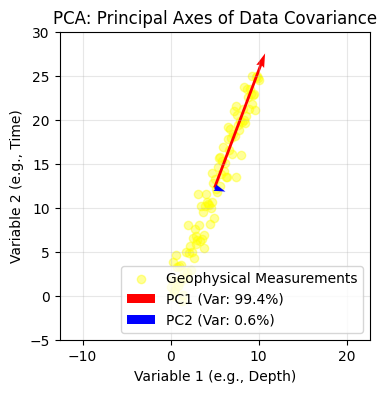

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. Generate Data: Suppose X is 'Depth' and Y is 'Travel Time'
np.random.seed(42)
x = np.linspace(0, 10, 100)
y = 2.5 * x + np.random.normal(0, 2, 100) # Correlation with noise
data = np.vstack([x, y]).T

# 2. PCA Calculation
pca = PCA(n_components=2)
pca.fit(data)

# Extract physical parameters
mu = pca.mean_                         # Center of mass
eigenvectors = pca.components_         # Directions (u1, u2)
eigenvalues = pca.explained_variance_  # Magnitude (sigma^2)

# 3. Plotting
plt.figure(figsize=(4, 4))
plt.scatter(data[:, 0], data[:, 1], c='yellow', alpha=0.4, label="Geophysical Measurements")

# Use quiver to plot vectors. 
# scale_units='dots' or 'xy' ensures they don't disappear.
origin_x, origin_y = mu

# Scaling the vectors by 2*sigma (capturing ~95% of the spread)
for i, color in zip(range(2), ['red', 'blue']):
    v = eigenvectors[i] * 2 * np.sqrt(eigenvalues[i])
    plt.quiver(origin_x, origin_y, v[0], v[1], color=color, 
               angles='xy', scale_units='xy', scale=1, width=0.009,
               label=f'PC{i+1} (Var: {pca.explained_variance_ratio_[i]*100:.1f}%)')

plt.axis('equal') 

# Fix the plot limits so the red arrow isn't cut off
plt.xlim(-5, 15); plt.ylim(-5, 30);plt.title("PCA: Principal Axes of Data Covariance")
plt.xlabel("Variable 1 (e.g., Depth)"); plt.ylabel("Variable 2 (e.g., Time)")
plt.legend(loc='lower right');plt.grid(True, alpha=0.3)
plt.show()

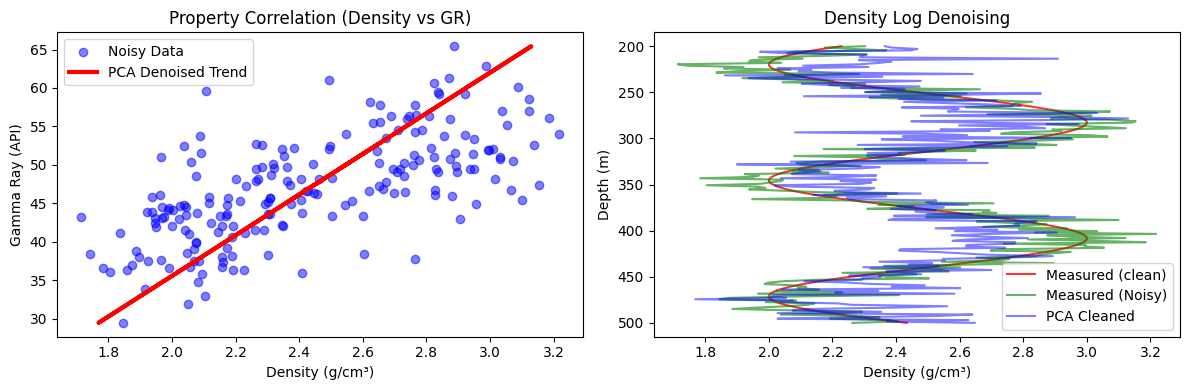

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Simulate Geological Signal (The "Clean" Physics)
# In Peru's copper-gold porphyries, higher density often correlates with mineralized zones
np.random.seed(42)
depth = np.linspace(200, 500, 200) # Depth from 200m to 500m
clean_density = 2.5 + 0.5 * np.sin(depth/20) # Simulated lithology changes
clean_gamma = 15 * clean_density + 10      # Underlying physical correlation

# 2. Add "Borehole Noise" (The "Real World" problem)
noise_density = clean_density + np.random.normal(0, 0.15, 200)
noise_gamma = clean_gamma + np.random.normal(0, 5, 200)

# Combine into a Data Matrix (X)
data_noisy = np.vstack([noise_density, noise_gamma]).T

# 3. Apply PCA for Compression/Denoising
pca = PCA(n_components=2)
pca.fit(data_noisy)
##pca.fit(data_scaled)

# --- THE COMPRESSION STEP ---
# We project the noisy data onto ONLY the first Principal Component (PC1)
# This discards PC2, which contains the random, uncorrelated noise.
data_transformed = pca.transform(data_noisy)
data_transformed[:, 1] = 0 # Kill the noise component (PC2)

# --- THE RECONSTRUCTION STEP ---
# Bring it back to the original units (Density and Gamma)
data_denoised = pca.inverse_transform(data_transformed)

# 4. Visualize the Result
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Plot A: The Correlation Space
ax[0].scatter(noise_density, noise_gamma, color='blue', alpha=0.5, label='Noisy Data')
ax[0].plot(data_denoised[:, 0], data_denoised[:, 1], color='red', linewidth=3, label='PCA Denoised Trend')
ax[0].set_title("Property Correlation (Density vs GR)")
ax[0].set_xlabel("Density (g/cm³)")
ax[0].set_ylabel("Gamma Ray (API)")
ax[0].legend()

# Plot B: The Log View (Depth vs Density)
ax[1].plot(clean_density, depth, color='red', alpha=0.8, label='Measured (clean)')
ax[1].plot(noise_density, depth, color='green', alpha=0.6, label='Measured (Noisy)')
ax[1].plot(data_denoised[:, 0], depth, color='blue', alpha=0.5, label='PCA Cleaned')
ax[1].invert_yaxis() # Depth goes down
ax[1].set_title("Density Log Denoising")
ax[1].set_xlabel("Density (g/cm³)")
ax[1].set_ylabel("Depth (m)")
ax[1].legend()

plt.tight_layout()
plt.show()

In [3]:
print(f"Signal (PC1): {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"Noise  (PC2): {pca.explained_variance_ratio_[1]*100:.2f}%")

Signal (PC1): 99.82%
Noise  (PC2): 0.18%


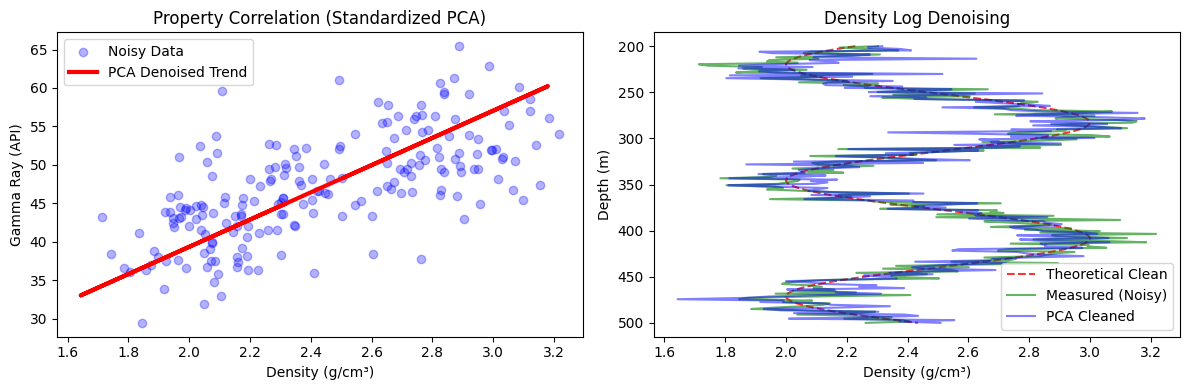

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Simulate Geological Signal
np.random.seed(42)
depth = np.linspace(200, 500, 200) 
clean_density = 2.5 + 0.5 * np.sin(depth/20) 
clean_gamma = 15 * clean_density + 10      

# 2. Add "Borehole Noise"
noise_density = clean_density + np.random.normal(0, 0.15, 200)
noise_gamma = clean_gamma + np.random.normal(0, 5, 200)

# Combine into a Data Matrix (X)
data_noisy = np.vstack([noise_density, noise_gamma]).T

# --- STANDARDIZATION ---
# This calculates z = (x - mean) / std
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_noisy)

# 3. Apply PCA on Scaled Data
pca = PCA(n_components=2)
# We fit on the unitless data
pca.fit(data_scaled)

# --- THE COMPRESSION STEP ---
data_transformed = pca.transform(data_scaled)
data_transformed[:, 1] = 0 # Kill the noise component (PC2)

# --- THE RECONSTRUCTION STEP ---
# 1. Back from PC space to Scaled space
data_rescaled = pca.inverse_transform(data_transformed)
# 2. Back from Scaled space to Original physical units (Density/Gamma)
data_denoised = scaler.inverse_transform(data_rescaled)

# 4. Visualize the Result
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Plot A: The Correlation Space
ax[0].scatter(noise_density, noise_gamma, color='blue', alpha=0.3, label='Noisy Data')
ax[0].plot(data_denoised[:, 0], data_denoised[:, 1], color='red', linewidth=3, label='PCA Denoised Trend')
ax[0].set_title("Property Correlation (Standardized PCA)")
ax[0].set_xlabel("Density (g/cm³)")
ax[0].set_ylabel("Gamma Ray (API)")
ax[0].legend()

# Plot B: The Log View (Depth vs Density)
ax[1].plot(clean_density, depth, color='red', linestyle='--', alpha=0.8, label='Theoretical Clean')
ax[1].plot(noise_density, depth, color='green', alpha=0.6, label='Measured (Noisy)')
ax[1].plot(data_denoised[:, 0], depth, color='blue', alpha=0.5, label='PCA Cleaned')
ax[1].invert_yaxis() 
ax[1].set_title("Density Log Denoising")
ax[1].set_xlabel("Density (g/cm³)")
ax[1].set_ylabel("Depth (m)")
ax[1].legend()

plt.tight_layout()
plt.show()

In [5]:
print(f"Signal (PC1): {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"Noise  (PC2): {pca.explained_variance_ratio_[1]*100:.2f}%")

Signal (PC1): 83.43%
Noise  (PC2): 16.57%


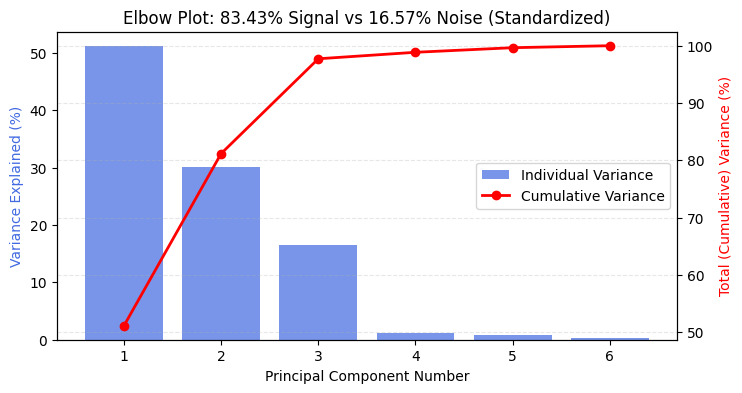

PC1: 51.12% (Cumulative: 51.12%)
PC2: 30.06% (Cumulative: 81.17%)
PC3: 16.55% (Cumulative: 97.72%)
PC4: 1.13% (Cumulative: 98.85%)
PC5: 0.80% (Cumulative: 99.65%)
PC6: 0.35% (Cumulative: 100.00%)


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Simulate 6 Geophysical Variables
np.random.seed(42)
n_samples = 500

# We create 3 "hidden" geological factors (The real physics)
factor1 = np.random.normal(0, 1, n_samples) # Lithology
factor2 = np.random.normal(0, 1, n_samples) # Mineralization
factor3 = np.random.normal(0, 1, n_samples) # Porosity/Fluid

# We map these factors to 6 observable sensors with added noise
density = 2.7 + 0.15 * factor1 - 0.2 * factor3 + 0.05 * np.random.randn(n_samples)
gamma_ray   = 40 + 20* factor1 + 5.0 * np.random.randn(n_samples)
resistivity = np.exp(4 - 0.8 * factor2 + 0.2 * np.random.randn(n_samples))
porosity = 0.1 + 0.08 * factor3 + 0.01 * np.random.randn(n_samples)
porosity = np.clip(porosity, 0.01, 0.4) # Physical constraint
sonic_time = 200 + 150 * factor3 + 10.0 * np.random.randn(n_samples)
mag_suscept = 1.5 +1.0* factor1 + 0.3 * np.random.randn(n_samples)

# Combine into a 500x6 matrix
X = np.column_stack([density, gamma_ray, resistivity, porosity, sonic_time, mag_suscept]) # sonic_time is P_wave time
feature_names = ['Density', 'Gamma', 'Resistivity', 'Porosity', 'Sonic', 'MagSus']

# 2. Standardize (Crucial for 6 different units!)
X_scaled = StandardScaler().fit_transform(X)

# 3. Apply PCA (asking for all 6 components)
pca = PCA(n_components=6)
pca.fit(X_scaled)

# 4. Create the Elbow Plot !!!! 
# When slope is low means that the next contributions add very little.
exp_var = pca.explained_variance_ratio_ * 100
cum_var = np.cumsum(exp_var)

fig, ax1 = plt.subplots(figsize=(8, 4))

# 1. Individual Variance (Bars)
bar = ax1.bar(range(1, 7), exp_var, alpha=0.7, color='royalblue', label='Individual Variance')
ax1.set_xlabel('Principal Component Number')
ax1.set_ylabel('Variance Explained (%)', color='royalblue')

# 2. Cumulative Variance (Line) # Is the addition of % of variace of each PCA component.
ax2 = ax1.twinx()
line = ax2.plot(range(1, 7), cum_var, marker='o', color='red', linewidth=2, label='Cumulative Variance')
ax2.set_ylabel('Total (Cumulative) Variance (%)', color='red')

# --- THE FIX FOR THE LEGEND ---
# We combine the handles from both axes manually
lns = [bar] + line
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='center right')

plt.title('Elbow Plot: 83.43% Signal vs 16.57% Noise (Standardized)')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

# Print the numbers
for i, val in enumerate(exp_var):
    print(f"PC{i+1}: {val:.2f}% (Cumulative: {cum_var[i]:.2f}%)")

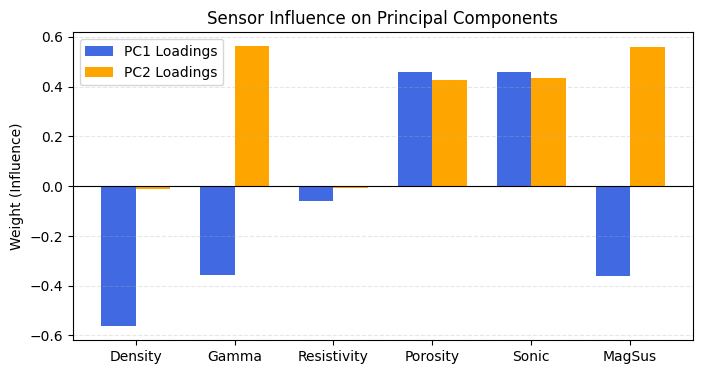

PC1 Loadings (The main Geological Trend):
Sonic          0.458810
Porosity       0.458063
Resistivity   -0.058371
Gamma         -0.358571
MagSus        -0.361575
Density       -0.562987
Name: PC1, dtype: float64


In [29]:
import pandas as pd

# Extract the loadings (eigenvectors)
loadings = pd.DataFrame(
    pca.components_.T, 
    columns=[f'PC{i+1}' for i in range(6)], 
    index=feature_names
)

# Plotting the loadings for the first two components (first 2 eingervectors)
fig, ax = plt.subplots(figsize=(8, 4))

# Define width of bars
width = 0.35
x = np.arange(len(feature_names))

ax.bar(x - width/2, loadings['PC1'], width, label='PC1 Loadings', color='royalblue')
ax.bar(x + width/2, loadings['PC2'], width, label='PC2 Loadings', color='orange')

ax.set_ylabel('Weight (Influence)')
ax.set_title('Sensor Influence on Principal Components')
ax.set_xticks(x)
ax.set_xticklabels(feature_names)
ax.axhline(0, color='black', linewidth=0.8)
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

print("PC1 Loadings (The main Geological Trend):")
print(loadings['PC1'].sort_values(ascending=False))

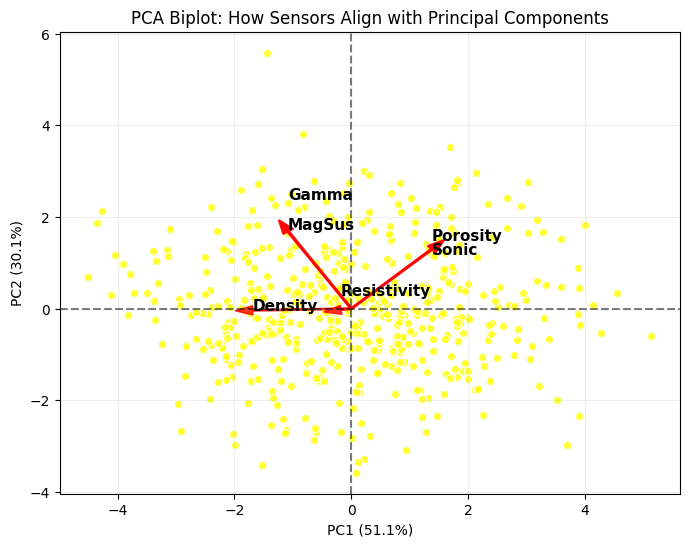

In [37]:
# --- THE BIPLOT (The Physicist's View of the Basis Change) ---
plt.figure(figsize=(8, 6))
# Project data into PC space
X_pca = pca.transform(X_scaled)

# Scatter plot of samples in the new PC1-PC2 coordinate system
# each dot is the sample of one place on surface (that has 6Dimensions), represented in 2D
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.8, c='yellow', edgecolors='white')

# Add arrows for the original features (Loadings)
# We scale them up so they are visible on the scatter plot
scale_factor = 3 
for i, feature in enumerate(feature_names):               # i from 1(Density) to 6(MagSus)
    plt.arrow(0, 0, pca.components_[0, i] * scale_factor, # PCA _1; i_st component 
              pca.components_[1, i] * scale_factor,       # PCA _2; i_st component 
              color='red', width=0.03, head_width=0.2, alpha=0.8)
    plt.text(pca.components_[0, i] * scale_factor, 
             pca.components_[1, i] * scale_factor * 1.2 + 0.4*np.sin(i*1.1), 
             feature, color='black', fontsize=11, fontweight='bold')

plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
plt.xlabel(f"PC1 ({exp_var[0]:.1f}%)"); plt.ylabel(f"PC2 ({exp_var[1]:.1f}%)")
plt.title("PCA Biplot: How Sensors Align with Principal Components"); plt.grid(alpha=0.2)
plt.show()